In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 準備訓練資料(Prepare training data)

In [2]:
df_boston_housing = pd.read_csv('BostonHousing.csv')
print(df_boston_housing.keys())
df_boston_housing

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RN', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')


,CRIM,ZN,INDUS,CHAS,NOX,RN,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


### 定義特徵和目標變數

In [3]:
X = df_boston_housing.drop('MEDV', axis=1)
y = df_boston_housing['MEDV']

### 切割資料
把資料切割成訓練training data（80%）和測試testing data（20%）

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 13)
(102, 13)
(404,)
(102,)


### 設定模型參數：
* objective: 'mse'
* num_leaves: 5

In [5]:
params = {
    'objective': 'mse',
    'num_leaves': 5
}

### 創建LightGBM數據集

In [6]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

### 訓練LightGBM模型

In [7]:
num_boost_round = 50
model = lgb.train(
    params,
    train_data,
    num_boost_round,
    valid_sets=[train_data, test_data],
    early_stopping_rounds=None,  # 不使用提前停止
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score 22.611881
[1]	training's l2: 72.5961	valid_1's l2: 71.8742
[2]	training's l2: 62.5815	valid_1's l2: 63.4914
[3]	training's l2: 54.0976	valid_1's l2: 57.0736
[4]	training's l2: 46.8499	valid_1's l2: 51.4172
[5]	training's l2: 41.0826	valid_1's l2: 47.6738
[6]	training's l2: 36.3267	valid_1's l2: 43.7964
[7]	training's l2: 32.1908	valid_1's l2: 40.8245
[8]	training's l2: 28.758	valid_1's l2: 38.2604
[9]	training's l2: 25.6897	valid_1's l2: 36.5904
[10]	training's l2: 23.2264	valid_1's l2: 35.338
[11]	training's l2: 21.0406	valid_1's l2: 34.2068
[12]	training's l2: 19.2971	valid_1's l2: 33.2508
[13]	training's l2: 17.6203	valid_1's l2: 32.5704
[14]	training's l

In [8]:
# 在測試集上進行預測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [9]:
# 計算 RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 4.97


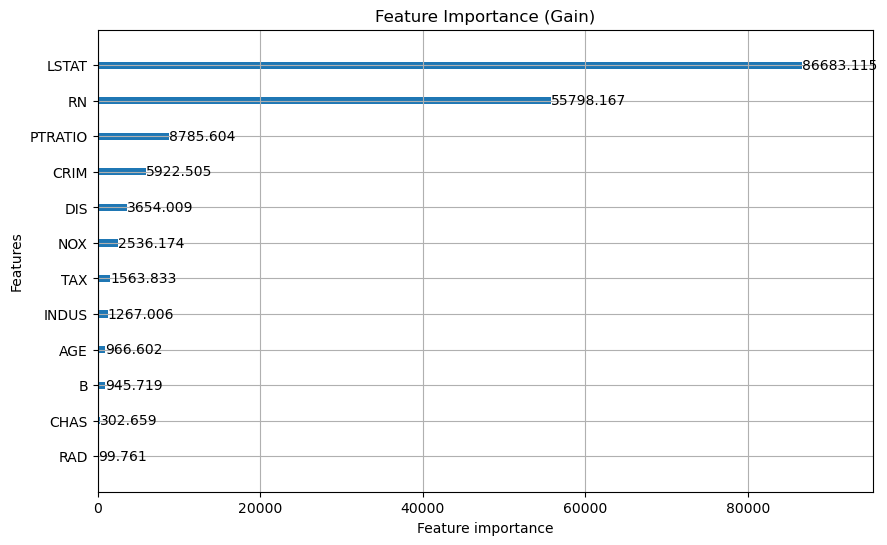

In [10]:
# 可視化特徵重要度
lgb.plot_importance(model, importance_type='gain', figsize=(10, 6), title='Feature Importance (Gain)')
plt.show()

<Figure size 2000x1000 with 0 Axes>

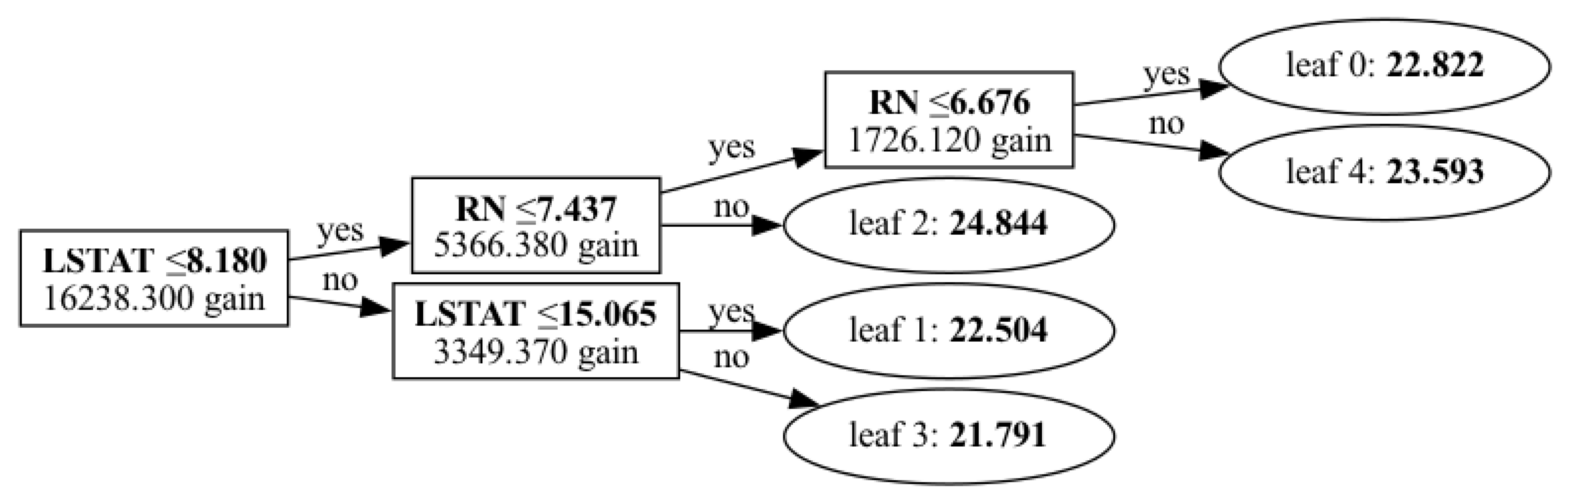

In [11]:
# 可視化第一棵樹
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain'])
plt.show()

<Figure size 2000x1000 with 0 Axes>

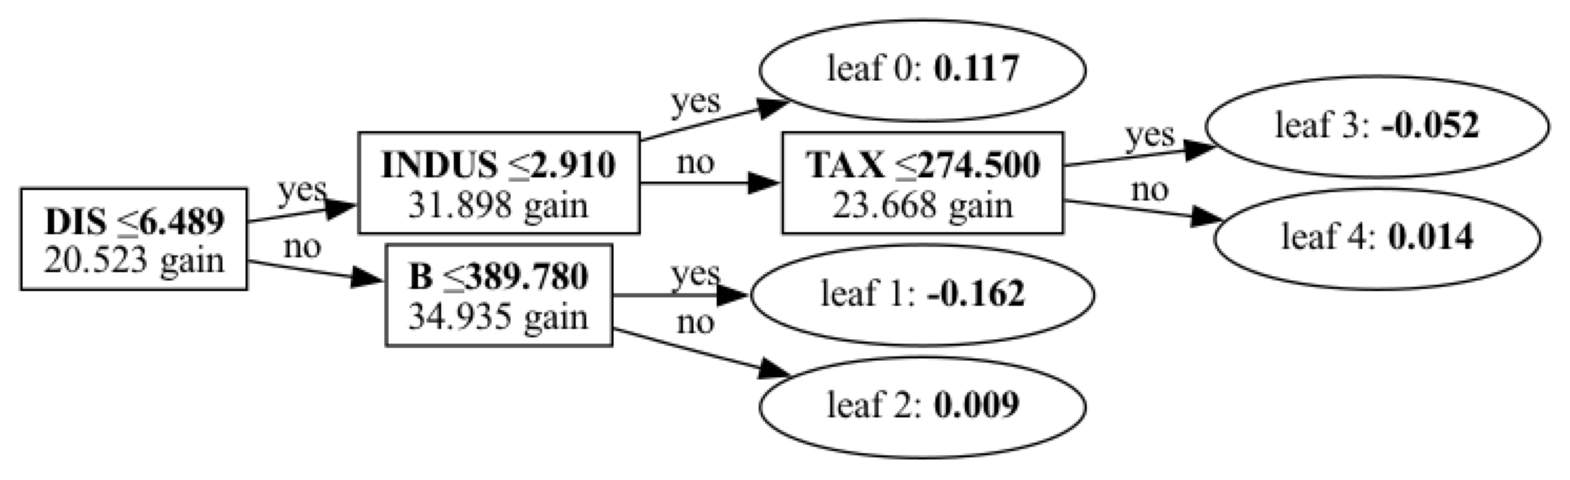

In [12]:
# 可視化第50棵樹
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=49, figsize=(20, 10), show_info=['split_gain'])
plt.show()

In [13]:
# 使用 SHAP 解釋模型的預測
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

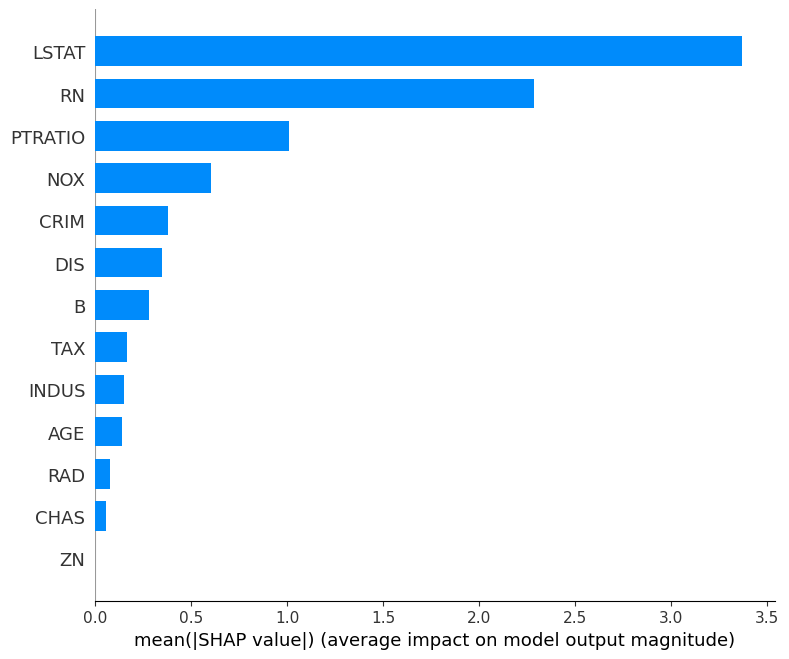

In [14]:
# 可視化 SHAP 摘要圖
shap.summary_plot(shap_values, X_test, plot_type='bar')